In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from math import log, exp
import seaborn as sns
from tqdm import tqdm, tqdm_pandas

In [2]:
def compute_repeat_sales_index(initial_year=1995):
    
    a=%system Rscript repeat_sales.R
    
    data = pd.read_csv('.rsi_index_per_bed.csv')

    data = data.rename(columns={'Unnamed: 0':'year'})

    data = data.bfill()

    data = data.replace('NONE', np.nan).dropna(axis=1)
    
    data['year'] = range(initial_year, initial_year+data.shape[0])
    
    data = data.set_index('year')
    
    data.to_csv('rsi_index_per_bed.csv')
    
    return data

In [3]:
def compute_repeat_rents_index(initial_year=1995):
    
    a=%system Rscript repeat_rents.R
    
    data = pd.read_csv('.rri_index_per_bed_2011_to_2019.csv')

    data = data.rename(columns={'Unnamed: 0':'year'})

    data = data.bfill()

    data = data.replace('NONE', np.nan).dropna(axis=1)
    
    data['year'] = range(initial_year, initial_year+data.shape[0])
    
    data = data.set_index('year')
    
    data.to_csv('rsi_index_per_bed.csv')
        
    return data

In [4]:
def infer_past_prices(serie):
    y, b, p = serie[['year', 'beds', 'price']]
    return ((log(p) - rri[str(b)][y]) + rri[str(b)]).apply(exp)

In [5]:
def compute_agg_rental_prices():
    rent_data_agg = pd.read_excel('voa-average-rent-borough.xls', sheet_name='Raw data', \
                              skiprows=2, \
                              usecols=['Year', 'Area', 'Category', 'Count of rents', 'Average'])

    rent_data_agg.head()

    # We filter the data by target region. As the data is not postcode-precise, 
    # the most accurate region would be NW (nortwest)
    rent_data_agg = rent_data_agg[rent_data_agg['Area'] == 'NORTH WEST'].drop('Area', 1)

    rent_data_agg['Category'].unique()

    # We filter by properties having a specific number of rooms
    rent_data_agg = rent_data_agg[~rent_data_agg['Category'].isin(['Room', 'All categories'])]


    beds_dict = {
        'Studio':0,
        'One Bedroom':1,
        'Two Bedroom':2,
        'Three Bedroom':3,
        'Four or more Bedrooms':4,
    }

    rent_data_agg['beds'] = rent_data_agg['Category'].apply(lambda x: beds_dict[x])

    rent_data_agg[['Count of rents', 'Average']] = rent_data_agg[['Count of rents', 'Average']].astype(int)

    rent_data_agg = rent_data_agg.groupby(['Year', 'beds'])['Count of rents', 'Average'].mean().reset_index()

    rent_data_agg.to_csv('rent_data_agg.csv')
    
    return rent_data_agg

In [6]:
# The repeat sales inde for the sales and the rents are calculated
rsi = compute_repeat_sales_index(1995)
rri = compute_repeat_rents_index(2011)

In [7]:
data_sales = pd.read_csv('nw6_data_sale.csv', index_col = 0)
data_sales = data_sales[data_sales['beds']>0]
data_sales = data_sales[data_sales['beds']<5]

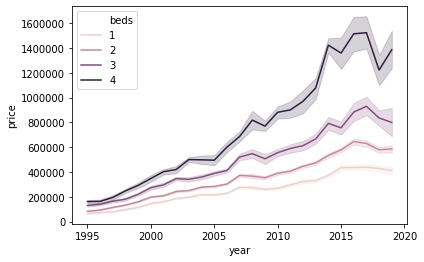

In [8]:
sns.lineplot(data=data_sales, y='price', x='year', hue='beds')

In [9]:
# Sale and renting data is loaded (calculated in web_scraping.ipynb)
data = pd.read_csv('nw6_data_rent.csv', index_col = 0)
data_sales = pd.read_csv('nw6_data_sale.csv', index_col = 0)
data_sales = data_sales[data_sales['beds']>0]
data_sales = data_sales[data_sales['beds']<5]
data_sales = data_sales[data_sales['year'] > 1996]
data = data[data['beds']<5]


In [10]:
inf_prices = data.apply(infer_past_prices, axis=1)

inf_prices = inf_prices.join(data)

inf_prices = inf_prices.dropna()

In [11]:
data = inf_prices.melt(id_vars=data.columns[0:8].tolist(),\
              value_vars=range(2012, 2020)).rename(columns=\
                                                   {'price':'real_price',
                                                    'year':'real_year',
                                                    'variable':'year',
                                                    'value':'price'})

In [12]:
data.to_csv('nw6_data_rent_prev_years_prediction.csv')

In [13]:
def infer_future_prices(serie):
    y, b, p = serie[['year', 'beds', 'price']]
    b = str(b+1)
    #y = max(1997, y)
    return (rsi.loc[y:2019,b] - rsi.loc[y,b] + log(p)).apply(exp)

In [14]:
inf_prices_sales = data_sales.apply(infer_future_prices, axis=1)

In [15]:
inf_prices_sales = data_sales.join(inf_prices_sales)

In [16]:
inf_prices_sales= inf_prices_sales.melt(id_vars=data_sales.columns.tolist(), value_vars=range(2012, 2020)).rename(columns=\
                                                   {'price':'real_price',
                                                    'year':'real_year',
                                                    'variable':'year',
                                                    'value':'price'})

In [17]:
inf_prices_sales.to_csv('nw6_data_price_fut_years_prediction.csv')

In [18]:
inf_prices_sales

,address,attributes,postcode,beds,real_price,date,real_year,year,price
0,"Flat 4, Elstow Grange 40-42, Brondesbury Park","Flat, Freehold, 3 Beds, 1 Bath, 1 Recep",NW6-7DW,3,140000,1998-11-01,1998,2012,5.848045e+05
1,"1, Broadhurst Mansions, 97 Broadhurst Gardens","Flat, Share of freehold, 3 Beds, 2 Baths, 1 Recep",NW6-3QP,3,197500,1998-06-01,1998,2012,8.249921e+05
2,"Ground And First Floor Flat, 24 Greencroft Gar...","Maisonette, Share of freehold, 3 Beds, 2 Baths...",NW6-3LS,3,265000,1998-02-01,1998,2012,1.106951e+06
3,36 West End Lane,"Flat, Leasehold, 3 Beds, 1 Bath, 1 Recep",NW6-4PA,3,139999,1998-08-01,1998,2012,5.848003e+05
4,44 Donaldson Road,"Flat, Share of freehold, 3 Beds, 3 Baths, 2 Re...",NW6-6NG,3,110000,1998-04-01,1998,2012,4.594893e+05
...,...,...,...,...,...,...,...,...,...
98539,303 West End Lane,"Flat, Leasehold, 3 Beds, 2 Baths, 1 Recep",NW6-1RD,3,580000,2019-03-01,2019,2019,5.800000e+05
98540,"Flat 48, Lyncroft Mansions, Lyncroft Gardens","Flat, Share of freehold, 3 Beds, 1 Bath, 1 Recep",NW6-1JX,3,690000,2019-07-01,2019,2019,6.900000e+05
98541,42a Hemstal Road,"Flat, Share of freehold, 3 Beds, 1 Bath, 1 Recep",NW6-2AJ,3,890501,2019-09-01,2019,2019,8.905010e+05
98542,"Flat 6, Kilburn Gate, Kilburn Priory","Flat, Leasehold, 3 Beds, 1 Bath, 1 Recep",NW6-5ND,3,440000,2019-01-01,2019,2019,4.400000e+05


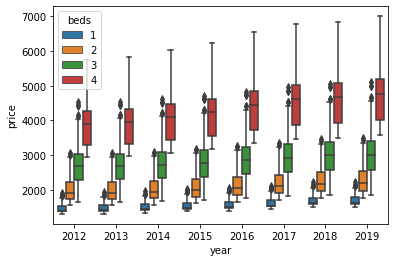

In [19]:
sns.boxplot(data=data, x='year', y='price', hue='beds')

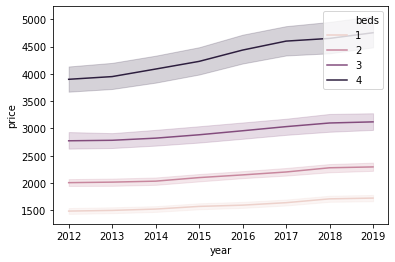

In [20]:
sns.lineplot(data=data, x='year', y='price', hue='beds')

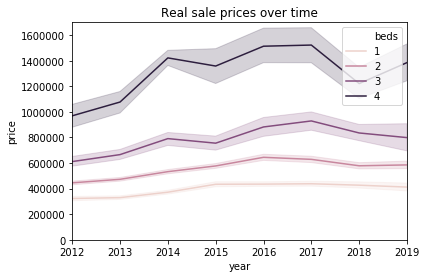

In [22]:
plt.xlim(2012, 2019)
plt.ylim(0, 1700000)
sns.lineplot(data=data_sales, x='year', y='price', hue='beds')
plt.title('Real sale prices over time')
plt.show()

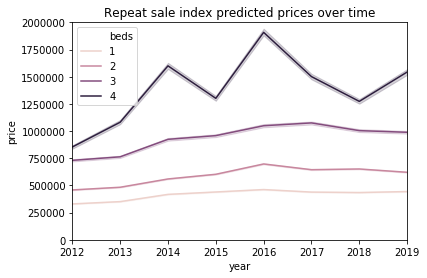

In [23]:
plt.xlim(2012, 2019)
plt.ylim(0, 2000000)
sns.lineplot(data=inf_prices_sales, x='year', y='price', hue='beds')
plt.title('Repeat sale index predicted prices over time')
plt.show()

In [24]:
rent_data_agg = compute_agg_rental_prices()
rent_data_agg = rent_data_agg[rent_data_agg['beds']>0]

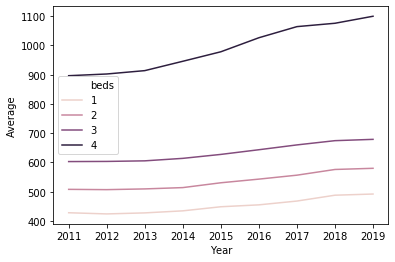

In [25]:
sns.lineplot(data=rent_data_agg, x='Year', y='Average', hue='beds')

Althought the trends are quite similar the absolute values are not. See email about this. In any case, the trends seem to make sense so they can be used.